In [4]:
import matplotlib
matplotlib.use("svg")
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from mpl_toolkits.axes_grid1 import ImageGrid
from scipy import spatial
from pandas import DataFrame as df
from datetime import datetime
import pandas as pd
import numpy as np
import collaborative_filtering as cf
import linear_regression as lr
import networkx as nx

links = pd.read_csv('./data/ml-latest-small/links.csv')
movies = pd.read_csv("./data/ml-latest-small/movies.csv")
ratings = pd.read_csv("./data/ml-latest-small/ratings.csv")
imdb_movies = pd.read_csv('./data/movie_objects.csv')

## Movie Recommendation - Midterm Report

The goal of this project is to build a movie recommender using more than collaborative filtering. Movie attributes from thousands of movies will be collected and analyzed to make educated recommendations. For now the project can be broken down into three parts:
* **Dataset compilation** 
* **Visualization** 
* **Recommendation model**

### Datasets Compilation

##### MovieLens 
This project will make use of the typical recommendation systems dataset known as the MovieLens dataset as compiled by Grouplens. Due to computational limitations, the smallest dataset (last updated 10/2016) will be explored rather than the complete 20M ratings one. 

The smallest dataset contains 100,000 ratings and 1,300 tag applications applied to 9,000 movies by 700 users. The dataset consists of four .csv files: links.csv, linking movies to IMDb and TMDb; movies.csv, containing movie title and genres; tags.csv, containing a tag or keyword for the movie; and ratings.csv, which has the movie ratings by the users. In addition, the users data included in the complete dataset will be used, taking only the users relevant to the small dataset.

http://grouplens.org/datasets/movielens/

##### IMDb

The scope of the MovieLens dataset is for collaborative filtering but it sets the ground for expansion with the links.csv. This project will make use of the IMDb IDs that are linked to each rated movie to collect movie information from IMDb itself. For the meantime, the fields that will be collected from IMDb are the following: cast, casting_director, cinematographer, countries, director, distributors, genres, id, languages, plot, producer, production company, rating, runtimes, stunt performer, title, visual effects, votes, writer, and year.

Unfortunately IMDb does not offer an official API to extract its data. The data, which is publicly available, could have been scraped for this project but instead an unofficial API called IMDbPY will be used. Their website is http://imdbpy.sourceforge.net/ and the library can be installed through pip with "pip install IMDbPY"

IMDbPY can be used to create a "movie object" by specifying the IMDbID of the movie and then the desired fields can be retrieved from this object. For example, the code below initializes the API object and will create a movie object for the movie with the IMDbID 114709. 

In [47]:
import imdb
imdbID = "114709"
imdb_api = imdb.IMDb()
movie_object = imdb_api.get_movie(imdbID)

In [3]:
print movie_object['title']
print movie_object['genres']
print movie_object['plot'][0]

Toy Story
[u'Animation', u'Adventure', u'Comedy', u'Family', u'Fantasy']
A little boy named Andy loves to be in his room, playing with his toys, especially his doll named "Woody". But, what do the toys do when Andy is not with them, they come to life. Woody believes that he has life (as a toy) good. However, he must worry about Andy's family moving, and what Woody does not know is about Andy's birthday party. Woody does not realize that Andy's mother gave him an action figure known as Buzz Lightyear, who does not believe that he is a toy, and quickly becomes Andy's new favorite toy. Woody, who is now consumed with jealousy, tries to get rid of Buzz. Then, both Woody and Buzz are now lost. They must find a way to get back to Andy before he moves without them, but they will have to pass through a ruthless toy killer, Sid Phillips.


The algorithm to create the database then goes this way:

* Read all IMDbIDs from the links.csv file. 
* While iterating through every IMDbID, create a IMDbPY movie object and extract and store only desired fields.
* Dump results into .csv file for later reference.

Below is a screenshot of how the .csv looks like. Fields that may contain more than one element are stored in lists. Also, for fields that involve entities (actors, directors, etc...), the values were stored as a list of tuples with their names and respective IMDbIDs. The IMDbIDs were stored just in case for future reference. 

<img src="./fig/output.jpeg">

###  Visualization

We began with getting an overview of the data. 

In [4]:
movieRating=ratings.merge(movies,on="movieId")
movieRating["title"]=movieRating.title.str.split(" \(").str.get(0)
movieRating["genres"]=movieRating.genres.str.split("|").str.get(0)

In [5]:
print "Number of Users: ",len(movieRating.userId.unique())
print "Number of Movies reviewed: ",len(movieRating.movieId.unique())

Number of Users:  671
Number of Movies reviewed:  9066


In [6]:
lastDate=movieRating.timestamp.max()
firstDate=movieRating.timestamp.min()

In [7]:
print "Start Date: ",datetime.fromtimestamp(firstDate)
print "End Date: ",datetime.fromtimestamp(lastDate)

Start Date:  1995-01-09 06:46:49
End Date:  2016-10-16 13:57:24


Here we saw the time frame within which the ratings were given

In [8]:
ratings_copy=ratings.iloc[:,:2]
connectedRating=ratings.iloc[:,:2].merge(ratings_copy,on=["movieId",ratings_copy.userId!=ratings.userId])
connectedRating=connectedRating[connectedRating.userId_x!=connectedRating.userId_y]
G=nx.Graph()
for line in connectedRating.itertuples():
    G.add_edge(line[1],line[3])

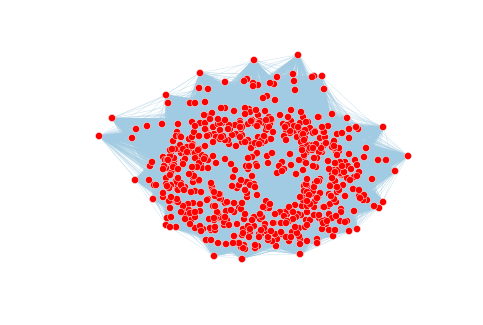

In [49]:
nx.draw(G,edge_color='#A0CBE2',width=0.25,node_size=50)
plt.show()

This shows that all users have some movies in common that they have rated. Hence, we do not need to exclude any of the user now.

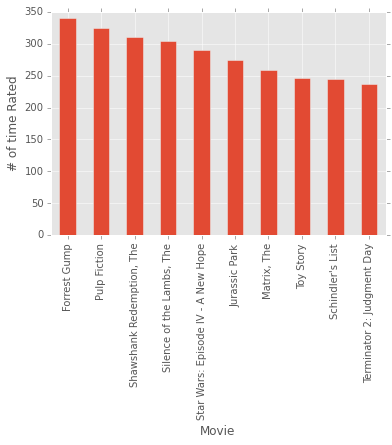

In [10]:
topMovie=movieRating.title.value_counts()[:10]
tm=topMovie.plot(kind='bar')
plt.ylabel('# of time Rated')
plt.xlabel("Movie")
plt.show()

The above chart shows the top 10 movies were rated the highest number of times

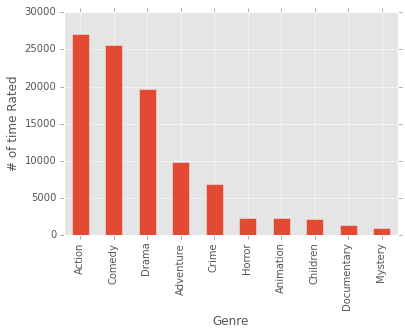

In [11]:
topGenre=movieRating.genres.value_counts()[:10]
tg=topGenre.plot(kind='bar')
plt.ylabel('# of time Rated')
plt.xlabel("Genre")
plt.show()

The above chart shows number of time each genre movie was rated.

Now we will look at some of the user features:

In [12]:
u_cols = ['userId', 'age', 'gender', 'occupation', 'zip_code']
user=(pd.read_csv("./data/u.user",sep='|',names=u_cols))[:671]
user.head()

,userId,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [13]:
print "Average age of users: ",user.age.mean()
print "Minimum age of user in data: ",user.age.min()
print "Maximum age of user in data: ",user.age.max()

Average age of users:  33.9925484352
Minimum age of user in data:  7
Maximum age of user in data:  73


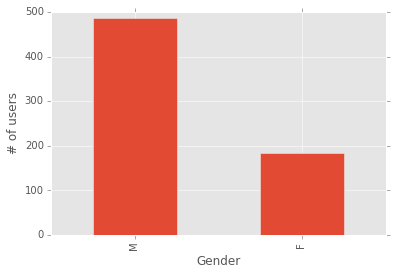

In [14]:
genderC=user.gender.value_counts()
gc=genderC.plot(kind='bar')
plt.ylabel('# of users')
plt.xlabel("Gender")
plt.show()

This graph higglights number of users in our data according to their gender.

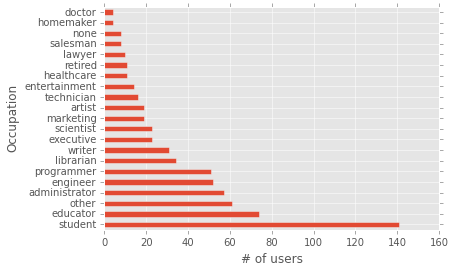

In [15]:
occC=user.occupation.value_counts()
oc=occC.plot(kind='barh')
plt.xlabel('# of users')
plt.ylabel("Occupation")
plt.show()

This graph shows the number of users according to their occupation.

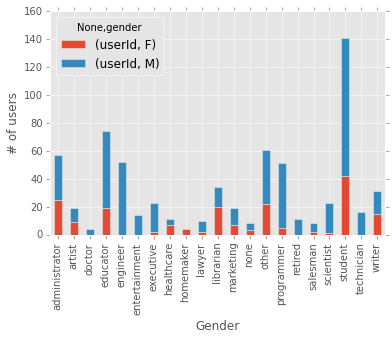

In [50]:
genderOccCategory=user[["occupation","gender","userId"]].groupby(by=["occupation","gender"]).count()
genderOccCategory.unstack().plot(kind="bar",stacked=True)
plt.ylabel('# of users')
plt.xlabel("Gender")
plt.show()

This graph helps us in understadning the ratio of Men to Women for each occupation in the data.
We need to clean the zip codes and segment users according to geographic location as well.
These infographics will help us in our model in later stages.

### Building the Recommendation Model 

#### Collaborative Filtering Overview

In collaberative-filtering, the matrix factorization method discovers latent features underlying the interactions between user and movie, assuming the inner product of user's latent features $u_i$ and movies latent $v_j$ is the rating:
$$h_\mathbf{\theta}(i,j) = \mathbf{u_i^T v_j}$$
Suppose there are $k$ latent features in $u$ and $v$. Then the model can be thought of describing how each latent feature $k$ matches to each other. For example, if the number of latent variables $k$ is 4:
$$\mathbf{u_i} = [0.4, 0.5, -0.3, 0.7]$$ $$\mathbf{v_j} = [0.2, -0.6, -0.2. 0.3]$$
The rating will be the inner product of these two vectors:
$$[0.4*0.2]_{feature1}+[0.5*(-0.6)]_{feature2}+[(-0.3)*(-0.2)]_{feature_3}+[0.7*0.3]_{feature4} = 0.05 $$

Then by minimizing the loss funtion, it is effectively finding the latent features and the coeficients that minimize the error of the reconstructed matrix compared to the training data.
$$\sum_{i,j\in S}\ell(h_\theta(i,j),\mathbf{X}_{ij}) + \lambda_u ||\mathbf{U}||_2^2 + \lambda_v ||\mathbf{V}||_2^2$$

#### Different Model

The motivation for this project is that there are some pitfalls with collaborative filtering: 
* It is hard to interpret the meaning of latent features.
* The inner product suggest that the rating is the linear combination of the latent features, which might not be true.
* There is a lot of information available that influences the rating which is not utilized. 

Instead of the collaborative filtering approach, the intuition that this project aims to follow is that each person is a regressor, where the input features are the defined movie attributes. In other word, it is equal to minimize the loss function for each person given rating history independently:
$$\sum_{j\in S}\ell(h_{\theta_i}(\mathbf{x}_j), \mathbf{X}_{ij}) $$, where i denotes a person and his/her preferences are encoded in parameter $\mathbf{\theta}_i$, $\mathbf{x}_j$ is the feature vector of the movie (with features such as genre, actors, year,etc...), and $h$ is the hypothesis function. For example, given a movie with features $m_j$={'1996', 'action, romance', ...}, a person with preferences $\theta_i$={'>1950', 'action || romance', ...} will output a rating value through a model $h$ (i.e. decision tree, SVM, cosine simlarity, ...).

#### 1. Linear Regression
Assume the rating is the output of the linear regression model:
$$h_{\theta_i}(\mathbf{x_j}) = \mathbf{\theta_i}^T\mathbf{x_j} $$, where $\theta_i$ is the user parameter and $x_j$ (k x 1) is the movie feature (k x 1).

The goal is to minimize the mean square error. For each user, the parameter could be solved by constructing a matrix $\mathbf{X}$ based on the past rating history, and it is a standard form of least square.
For example, if user i rated m movies, the equation will be: 

$$\mathbf{\theta_i^*} = \arg \min_{\theta} ||\mathbf{X\theta - y}||_2$$, where $\mathbf{X}$ is a m x k matrix and each row is a movie feature vector $\mathbf{x}$, $\mathbf{\theta_i}$ is a k x 1 column vector of user i's parameter.

In this experiement, three numeric feature {'year', 'runtime', 'vote'} are selected as the movie feature (i.e k = 3), and the number of user and movies are as same as the collaberative filter setting.

In [5]:
np.random.seed(10)
# Collaberative Filtering
reload(cf)
X_tr, X_te, movieNames, idxToLenId = cf.process(ratings, movies, np.random.permutation(len(ratings)))
U_cf, V_cf = cf.train(X_tr, X_te, k = 3, lam = 1, niters = 51, verbose = True)

Iter: 000	train error: 9.225	Test error: 9.3275
Iter: 005	train error: 0.536	Test error: 1.2627
Iter: 010	train error: 0.514	Test error: 1.2903
Iter: 015	train error: 0.500	Test error: 1.2918
Iter: 020	train error: 0.496	Test error: 1.3001
Iter: 025	train error: 0.495	Test error: 1.3044
Iter: 030	train error: 0.495	Test error: 1.3081
Iter: 035	train error: 0.495	Test error: 1.3122
Iter: 040	train error: 0.495	Test error: 1.3157
Iter: 045	train error: 0.495	Test error: 1.3180
Iter: 050	train error: 0.495	Test error: 1.3195


In [20]:
# Linear Regression
reload(lr)
V_lr = lr.process(imdb_movies, idxToLenId, links, features = ['year', 'votes', 'runtimes'])
U_lr = lr.train(X_tr, V_lr, lam = 1)

Below is the experiement result comparing with the collaberative filtering method as a baseline, using the some evaluation metric. Although the training error is higher, the testing error is actually lower than the collaberative filtering method.

### References

F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4, Article 19 (December 2015), 19 pages. DOI=http://dx.doi.org/10.1145/2827872